# Preprocess the block-slide image pair before the QC step

### Import the necessary libraries

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Read images

In [2]:
# Read all images
import os

slides = []
blocks = []

path = './img/Slides/'
files = os.listdir(path)
for index, file in enumerate(files):
    # convert image from BGR to RGB
    img_sld = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    slides.append(img_sld)

path = './img/Blocks/'
files = os.listdir(path)
for index, file in enumerate(files):
    # convert image from BGR to RGB
    img_blk = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    blocks.append(img_blk)

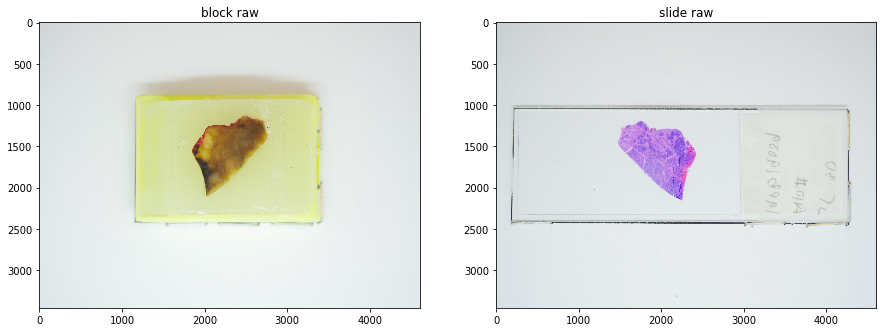

In [69]:
# Select the sample pair that we are going to work with
sample_index = 4
img_slide = slides[sample_index].copy()
img_block = blocks[sample_index].copy()


# Display the raw images
plt.figure(figsize=(15,8))

plt.subplot(121)
plt.title('block raw')
plt.imshow(img_block)

plt.subplot(122)
plt.title('slide raw')
plt.imshow(img_slide)

plt.show()

### Preprocess function
* The functions take in the block-slide image pair, and return the processed block-slide image pair.
* The following must be corrected:
    1. Orientations
    2. Exposure level
    3. Colour correction (RGB to Grayscale)

In [44]:
def show1img(img, img_title):
    figure_size = 10
    plt.figure(figsize=(figure_size, figure_size))
    plt.imshow(img)
    plt.title(img_title)

    plt.show()


def show2img(img1, img1_title, img2, img2_title):
    figure_size = 20
    plt.figure(figsize=(figure_size, figure_size))
    plt.subplot(1, 2, 1), plt.imshow(img1)
    plt.title(img1_title), plt.xticks([]), plt.yticks([])
    plt.subplot(1, 2, 2), plt.imshow(img2)
    plt.title(img2_title), plt.xticks([]), plt.yticks([])

    plt.show()


def crop(image, x1, x2, y1, y2):
    height = image.shape[0]
    width = image.shape[1]
    cropped = image[y1:y2, x1:x2]
    return cropped.copy()

def FlipImg(img, direction):
    return cv2.flip(img, direction).copy()

In [56]:
def GetKMeansSeg(image, K, attempts):

    vectorized = image.reshape((-1, 3)).copy()
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    ret, label, center = cv2.kmeans(
        vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    image_kmean = res.reshape((image.shape))

    return image_kmean.copy()


def GetAdativeThres(image_gray):
    # blur and grayscale before thresholding
    k = 9
    blur = cv2.GaussianBlur(
        src=image_gray,
        ksize=(k, k),
        sigmaX=0)

    # perform adaptive thresholding
    (t, image_thres) = cv2.threshold(src=blur,
                                     thresh=0,
                                     maxval=255,
                                     type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return image_thres.copy()


def GetContours(image, image_thres):
    image_with_cnts = image.copy()

    image_thres = cv2.erode(image_thres, None, iterations=10)
    image_thres = cv2.dilate(image_thres, None, iterations=5)

    cnts = cv2.findContours(image_thres, cv2.RETR_TREE,
                            cv2.CHAIN_APPROX_SIMPLE)[1]
    cv2.drawContours(image_with_cnts, cnts, -1, (0, 255, 255), 5)

    return image_with_cnts, cnts


def CropByContour(image, cnts):
    min_area = 30000
    max_area = 2000000
    box = np.zeros(shape=image.shape, dtype="uint8")
    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area and area < max_area:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(img=box,
                          pt1=(x, y),
                          pt2=(x + w, y + h),
                          color=(255, 255, 255),
                          thickness=-1)

    boxed = cv2.bitwise_and(src1=image, src2=box)
    image_cropped = image[y:y+h, x:x+w]

    return box, boxed, image_cropped

In [45]:
def pre_slide(img_slide):
    image = crop(img_slide, 310, 2690, 1060, 2330)

    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#     # k-means segmentaion
#     image_kmean = GetKMeansSeg(image, 2, 10)
#     image_gray_kmean = cv2.cvtColor(image_kmean, cv2.COLOR_RGB2GRAY)

    # Adaptive thresholding
    image_thres = GetAdativeThres(image_gray)

    # make a mask suitable for color images
    image_thres_bw = cv2.merge(mv=[image_thres, image_thres, image_thres])
    image_thres_bw = 255 - image_thres_bw
    image_thres_bw[:20] = 0
    image_thres_bw[-20:] = 0
    # use the mask to select the remove background
    image_noBg = cv2.bitwise_and(src1=image, src2=image_thres_bw)
    image_noBg[image_noBg == 0] = 255

    image_with_cnts, cnts = GetContours(image_thres_bw, image_thres)

    box, boxed, image_cropped = CropByContour(image_noBg, cnts)
    
    
    image_gray_box = cv2.cvtColor(box, cv2.COLOR_RGB2GRAY)
    # Adaptive thresholding
    image_thres_box = GetAdativeThres(image_gray_box)

    # make a mask suitable for color images
    image_thres_bw_box = cv2.merge(mv=[image_thres_box, image_thres_box, image_thres_box])
    image_thres_bw_box = 255 - image_thres_bw_box

    image_with_cnts_box, cnts_box = GetContours(box, image_thres_box)

    new_box, new_boxed, image_out = CropByContour(image_thres_bw, cnts_box)


#     # show the output
#     show1img(image, 'original')
#     # show1img(image_kmean, 'K-means segmentation')
#     # show1img(image_thres, 'image_thres')
#     # show1img(image_thres_bw, 'Threshold image')
#     # show1img(image_noBg, 'Removed background')
#     # show1img(image_with_cnts, 'contour')
#     show1img(new_boxed, 'boxed')
#     show1img(image_out, 'cropped')
    
    return FlipImg(FlipImg(image_out, 0), -1)

# for img_slide in slides:
#     pre_slide(img_slide)

In [41]:
def pre_block(img_block):
    image = crop(img_block, 1300, 3200, 1000, 2300)

    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#     # k-means segmentaion
#     image_kmean = GetKMeansSeg(image, 2, 10)
#     image_gray_kmean = cv2.cvtColor(image_kmean, cv2.COLOR_RGB2GRAY)

    # Adaptive thresholding
    image_thres = GetAdativeThres(image_gray)

    # make a mask suitable for color images
    image_thres_bw = cv2.merge(mv=[image_thres, image_thres, image_thres])
    image_thres_bw = 255 - image_thres_bw

    # use the mask to select the remove background
    image_noBg = cv2.bitwise_and(src1=image, src2=image_thres_bw)
    image_noBg[image_noBg == 0] = 255

    image_with_cnts, cnts = GetContours(image_thres_bw, image_thres)

    box, boxed, image_cropped = CropByContour(image_noBg, cnts)
    
    
    image_gray_box = cv2.cvtColor(box, cv2.COLOR_RGB2GRAY)
    # Adaptive thresholding
    image_thres_box = GetAdativeThres(image_gray_box)

    # make a mask suitable for color images
    image_thres_bw_box = cv2.merge(mv=[image_thres_box, image_thres_box, image_thres_box])
    image_thres_bw_box = 255 - image_thres_bw_box

    image_with_cnts_box, cnts_box = GetContours(box, image_thres_box)

    new_box, new_boxed, image_out = CropByContour(image_thres_bw, cnts_box)


#     # show the output
#     show1img(image, 'original')
#     # show1img(image_kmean, 'K-means segmentation')
#     # show1img(image_thres, 'image_thres')
#     show1img(image_thres_bw, 'Threshold image')
#     show1img(image_noBg, 'Removed background')
#     show1img(image_with_cnts, 'contour')
#     show1img(boxed, 'boxed')
#     # show1img(new_boxed, 'boxed')
#     show1img(image_out, 'cropped')
    
    return image_out

# for img_block in blocks:
#     pre_block(img_block)

error: OpenCV(3.4.2) /io/opencv/modules/imgproc/src/thresh.cpp:1406: error: (-215:Assertion failed) src.type() == (((0) & ((1 << 3) - 1)) + (((1)-1) << 3)) in function 'threshold'


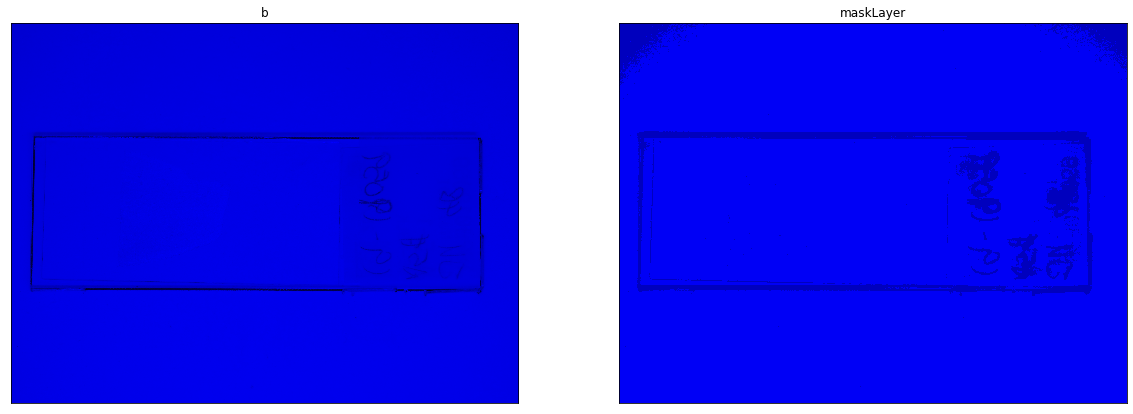

In [344]:
image = img_slide
# print("R: {}, G: {}, B: {}".format(image[:, :, 0],image[:, :, 1],image[:, :, 2]))

r = image.copy()
# set blue and green channels to 0
r[:, :, 1] = 0
r[:, :, 2] = 0


g = image.copy()
# set blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0

b = image.copy()
# set green and red channels to 0
b[:, :, 0] = 0
b[:, :, 1] = 0


# show1img(r, 'red')
# show1img(g, 'green')
# show1img(b, 'blue')

def getMask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 0)

    # k-means segmentaion
    vectorized = image.reshape((-1, 3)).copy()
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    attempts = 15
    ret, label, center = cv2.kmeans(
        vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    kmean_seg = res.reshape((image.shape))
    
    return kmean_seg

maskLayer = getMask(b)
show2img(b,'b', maskLayer, 'maskLayer')

In [349]:
# just use the rgb values for comparison
color = [246, 213, 139]   # Original value
black = [0,0,0]
white = [255,255,255]
mask = np.all(rgb == color, axis = -1)
# change all pixels that match color to white
image[mask] = white

show1img()

OSError: cannot write mode RGBA as JPEG

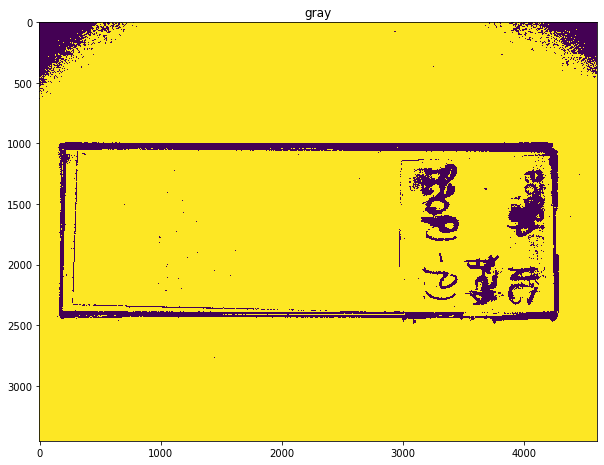

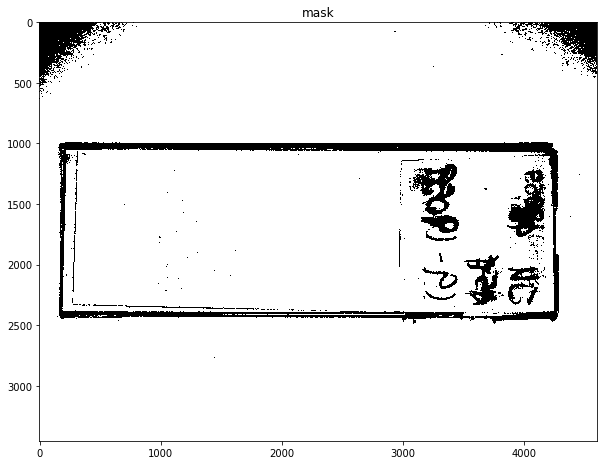

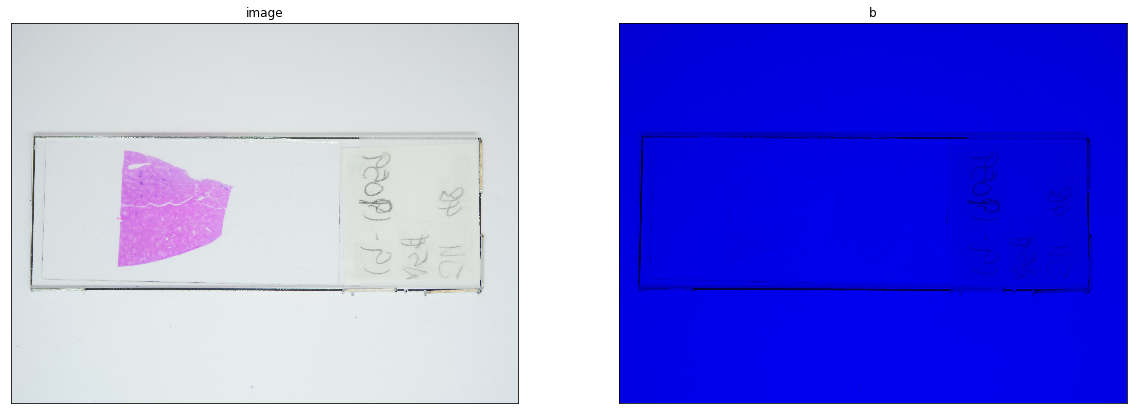

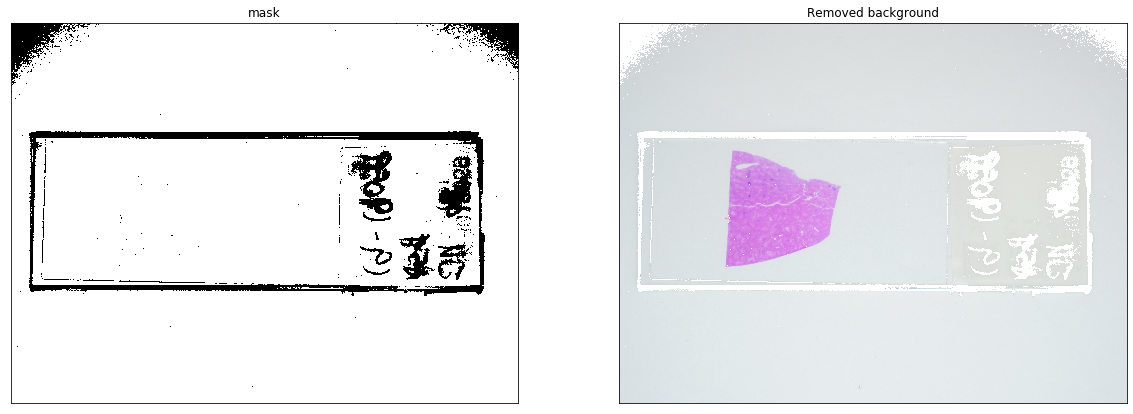

In [345]:
gray = maskLayer.copy()
gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
show1img(gray, 'gray')

# make a mask suitable for color images
mask = cv2.merge(mv=[gray, gray, gray])
# mask = 255 - mask
mask[mask < 25] = 0
mask[mask >= 25] = 255
show1img(mask, 'mask')


# use the mask to select the "interesting" part of the image
no_bg = cv2.bitwise_and(src1=image, src2=mask)
no_bg[no_bg == 0] = 255

show2img(image, 'image', b, 'b')
show2img(mask, 'mask', no_bg, 'Removed background')

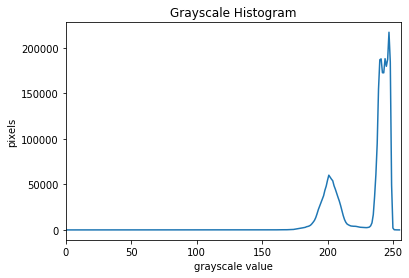

In [126]:
# Create histogram

histogram = cv2.calcHist(images = [image_gray], 
    channels = [0], 
    mask = None, 
    histSize = [256], 
    ranges = [0, 256])

# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0, 256]) # <- named arguments do not work here

plt.plot(histogram) # <- or here
plt.show()

In [35]:
def preprocess(img_block, img_slide):
    
    # Add your code here
    
    img_block_prprocessed = pre_block(img_block)
    img_slide_preprocessed = pre_slide(img_slide)
    
    return (img_block_prprocessed, img_slide_preprocessed)

### Run the function

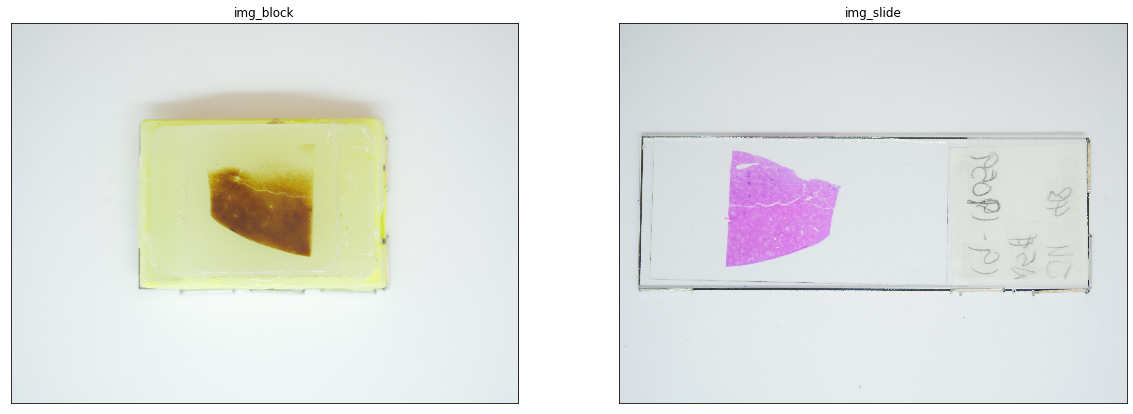

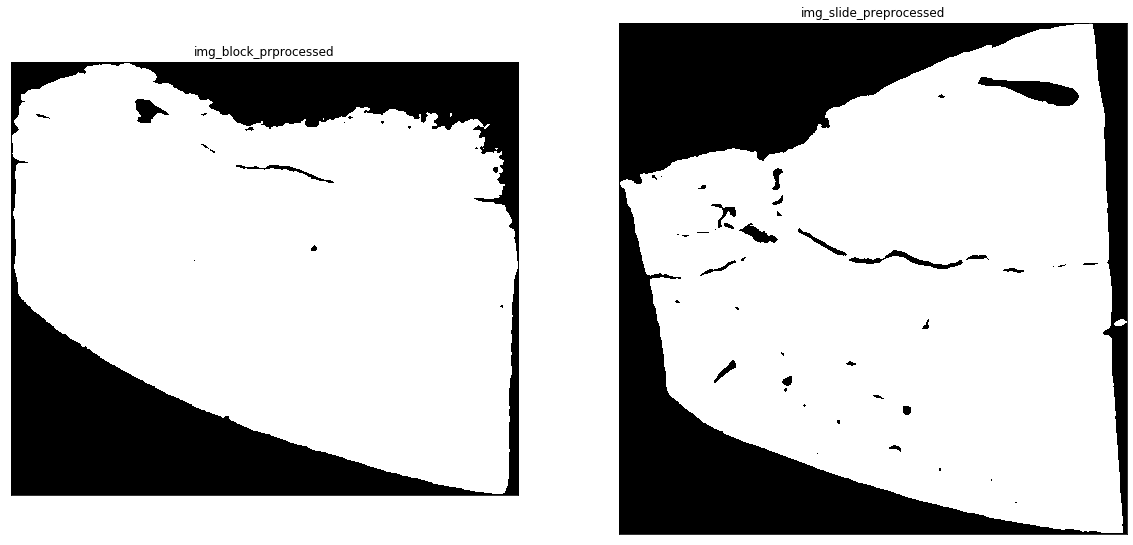

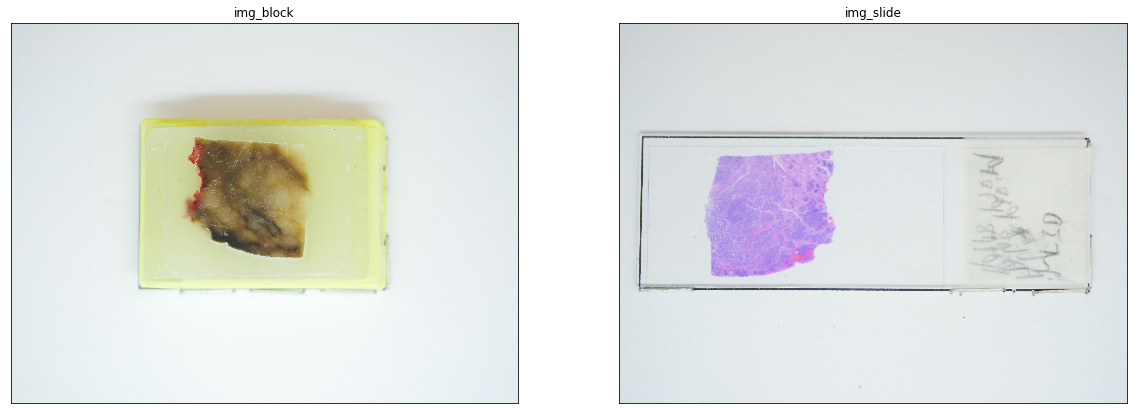

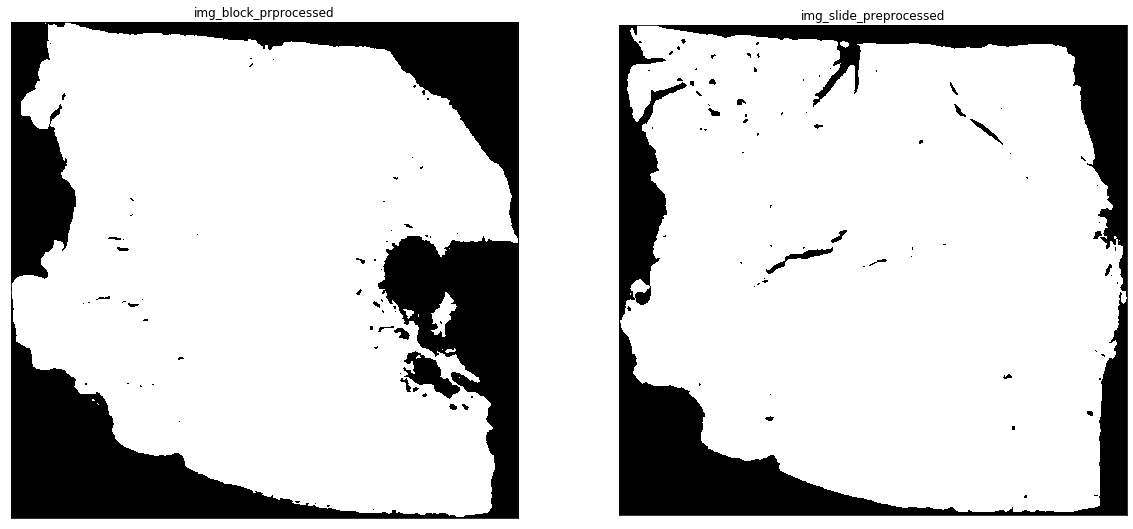

In [66]:
# Select the sample pair that we are going to work with
for i in range(18,20):
    sample_index = i
    img_block = blocks[sample_index].copy()
    img_slide = slides[sample_index].copy()
    
    show2img(img_block, 'img_block', img_slide, 'img_slide')
    
    img_block_prprocessed, img_slide_preprocessed = preprocess(img_block, img_slide)
    show2img(img_block_prprocessed, 'img_block_prprocessed', img_slide_preprocessed, 'img_slide_preprocessed')
    
    cv2.imwrite('./img/{}_blk_processed.jpg'.format(i), img_block_prprocessed) 
    cv2.imwrite('./img/{}_sld_processed.jpg'.format(i), img_slide_preprocessed) 